In [173]:
%matplotlib inline

import os
import re
import json
import pandas as pd
import numpy as np
from functools import partial
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
#from multiprocessing import Pool, Process
from ckonlpy.tag import Twitter
import json
import ijson
from collections import Counter
from gensim.models import Word2Vec, FastText

from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

import seaborn as sns
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

sns.set(style='ticks')
rcParams['font.family'] = u'Malgun Gothic'

# 나중에, 가성비 같은 단어들도 사전에 추가해주자

In [3]:
with open('twitter_data/qry.json') as f:
    qry = json.load(f)
    
new_words = list(set(sum([re.findall(r'#([^ ]+)', v)+[k] for k,v in qry.items()], [])))

In [4]:
new_words

['eider',
 '몽벨',
 'yoshidaporter',
 'yojiyamamoto',
 'dailypaper',
 'jwanderson',
 '카피탈',
 'prada',
 'barrel',
 'dynafit',
 'ragandbone',
 'canadagoose',
 'abecrombiefitch',
 '몽클레르',
 '아디다스오리지널',
 'incase',
 'helmutlang',
 'pearlygates',
 '99퍼센트이즈',
 '걸스돈크라이',
 'undftd',
 'brixton',
 'saintlaurent',
 'cherryla',
 '스포츠웨어',
 'poloralphlauren',
 'stoneisland',
 'thursdayisland',
 'charms',
 'lafuma',
 '헤리티지플로스',
 '의류',
 'doublet',
 'bally',
 'gucci',
 '와이쓰리',
 'cutlerandgross',
 '미유미유',
 'pleatsplease',
 '니들스',
 'needles',
 'plac',
 'hagt',
 '이자벨마랑',
 'columbia',
 '폴로랄프로렌',
 '잔스포츠',
 '발망',
 '제이린드버그',
 '버켄스탁',
 '에이프',
 '미즈노',
 '버커루',
 '컬럼비아',
 'cpcompany',
 'abecrombie',
 '생로랑',
 'streetwear',
 'nerdy',
 'ferragamo',
 '뉴발란스',
 '인케이스',
 '닥터마틴',
 '레이닝챔프',
 '레디메이드',
 '젠틀몬스터',
 'yoshida',
 'readymade',
 '페레가모',
 '베자',
 'tods',
 '앰씨앰',
 '디스커버리',
 'salvatoreferregamo',
 '앨앰씨',
 'plasticisland',
 'soup',
 '비츠바이닥터드레',
 '디키즈',
 'vejasneakers',
 '허프',
 'series',
 '참스',
 '톰스슈즈',
 '옷',
 '스포츠패션',
 'mun

In [6]:
twitter = Twitter()
twitter.add_dictionary(new_words, 'Noun')

In [8]:
srcdir = 'twitter_data'
textcol = 'text'
fnames = [srcdir + '/' + fname for fname in os.listdir(srcdir)];fnames

['twitter_data/032c (2010.01.01-2019.01.31).pkl',
 'twitter_data/1017alyx9sm (2010.01.01-2019.01.31).pkl',
 'twitter_data/8seconds (2010.01.01-2019.01.31).pkl',
 'twitter_data/99percentis (2010.01.01-2019.01.31).pkl',
 'twitter_data/a.p.c (2010.01.01-2019.01.31).pkl',
 'twitter_data/aape (2010.01.01-2019.01.31).pkl',
 'twitter_data/abecrombiefitch (2010.01.01-2019.01.31).pkl',
 'twitter_data/acnestudios (2010.01.01-2019.01.31).pkl',
 'twitter_data/acoldwall (2010.01.01-2019.01.31).pkl',
 'twitter_data/acronym (2010.01.01-2019.01.31).pkl',
 'twitter_data/adererror (2010.01.01-2019.01.31).pkl',
 'twitter_data/adidas (2010.01.01-2019.01.31).pkl',
 'twitter_data/adidasoriginal (2010.01.01-2019.01.31).pkl',
 'twitter_data/advisoryboardcrystals (2010.01.01-2019.01.31).pkl',
 'twitter_data/aecawhite (2010.01.01-2019.01.31).pkl',
 'twitter_data/aimeleondore (2010.01.01-2019.01.31).pkl',
 'twitter_data/aldo (2010.01.01-2019.01.31).pkl',
 'twitter_data/alexandermcqueen (2010.01.01-2019.01.31).pk

In [9]:
tokens_dict = {}
for fname in tqdm_notebook(fnames):
    try:
        item, tokenized = tokenize(fname, textcol)
        tokens_dict[item] = tokenized
    except:
        pass

In [10]:
with open('twitter_data/tokens_dict.json', 'w') as f:
    json.dump(tokens_dict, f)

In [2]:
with open('tokens_dict.json') as f:
    tokens_dict = json.load(f)

## 토큰.txt 는 브랜드별로 관리. 다운로드.json 은 브랜드별/날짜구간별로 관리

# Word2Vec: 잘됨

In [27]:
w2v = Word2Vec(sum(tokens_dict.values(), []), size=100, window=5, min_count=10, workers=4, sg=1)
w2v.save('twitter_data/word2vec.model')

In [28]:
w2v.init_sims(replace=True)

In [3]:
w2v = Word2Vec.load('word2vec.model')

In [4]:
#['팁', '가성', '유행', '무난', '신뢰', '럭셔리', '과감', '유니크', '리더', '스포츠', '저렴', '대충']
w2v.wv.most_similar(positive=['art'], topn=20)

[('sword', 0.756505012512207),
 ('trivia', 0.7105209827423096),
 ('범민', 0.6921910047531128),
 ('인물화', 0.6862059831619263),
 ('artistic', 0.68367999792099),
 ('tattoodesign', 0.6824052333831787),
 ('ipadpro', 0.682239830493927),
 ('painting', 0.6822101473808289),
 ('illustrationart', 0.6818537712097168),
 ('fineart', 0.6813533306121826),
 ('bfmin', 0.6810145378112793),
 ('abstract', 0.6804133653640747),
 ('artsy', 0.6793262362480164),
 ('linetattoo', 0.6773720979690552),
 ('paint', 0.6765545606613159),
 ('gogh', 0.6740577220916748),
 ('letterings', 0.6619492769241333),
 ('colortattoo', 0.661650538444519),
 ('acrylic', 0.6572695374488831),
 ('graphics', 0.6562869548797607)]

In [5]:
id_pools = {
    '가성비': ['가성','저렴','효율','성능','실용'], 
    '트렌디': ['유행','트렌드','trend','trendy','민감'],
    '신뢰성': ['신뢰','믿음','trust','견고','품질','안정','클래식','classic'],
    '럭셔리': ['럭셔리','품격','고급','호화','luxury'],
    '유니크': ['유니크','독특','독창','unique','개성','only','참신','특이'],
    '활동성': ['활동','활발','운동','액티브','스포츠','active','sport','sports','sporty'],
    '과감함': ['과감','선도','선구','대담','강렬','선명','예술','art'],
    # 철학, 정통, 격식, 아이디어, 변화, 변동, 환상, 신상, 새로운, 튀는, 
}, 

# FastText는 한글에서 잘 안먹히는 것 같다

In [32]:
sentences = sum(tokens_dict.values(), [])
fasttext = FastText(size=100, window=5, min_count=10)
fasttext.build_vocab(sentences=sentences)
fasttext.train(sentences=sentences, total_examples=len(sentences), epochs=10)
fasttext.save('twitter_data/fasttext.model')

In [33]:
fasttext.init_sims(replace=True)

In [34]:
fasttext = FastText.load('twitter_data/fasttext.model')

In [35]:
fasttext.wv.most_similar(positive=['나이키'], topn=10)

[('이키', 0.7119917869567871),
 ('나이테', 0.6592456102371216),
 ('나이트런', 0.581122636795044),
 ('sb', 0.5587837100028992),
 ('ナイキ', 0.557768702507019),
 ('에어', 0.5537333488464355),
 ('gyakusou', 0.5514733791351318),
 ('머큐리얼', 0.5435261726379395),
 ('덩크', 0.5427482724189758),
 ('포짓', 0.5412664413452148)]

In [6]:
docs = sum(tokens_dict.values(), [])

In [39]:
dct = Dictionary(docs)
dct.filter_extremes(no_below=20, no_above=0.2)
dct.compactify()

In [40]:
corp = {brand:[dct.doc2bow(doc) for doc in docs] for brand, docs in tqdm_notebook(tokens_dict.items())}

In [41]:
model_tfidf = TfidfModel(sum(corp.values(),[]), id2word=dct)

In [63]:
def get_brand_vecs(bname):
    brand_tfidf  = model_tfidf[corp[bname]]
    return np.vstack([sparse2full(c, len(dct)) for c in brand_tfidf]).mean(axis=0)

In [43]:
words = list(dct.values())
identities = list(id_pools.keys())
brands = list(tokens_dict.keys())

In [44]:
sim_mat = np.zeros((len(identities),len(words)))
for i, idty in enumerate(tqdm_notebook(identities)):
    for j, word in enumerate(words):
        sims = []
        for w in id_pools[idty]:
            try:
                sims.append(w2v.wv.similarity(w, word))
            except:
                sims.append(0)
        sim_mat[i,j] = np.mean(sims)
        #sim_mat[i,j] = np.mean([w2v.wv.similarity(w, word) for w in id_pools[idty]])

In [45]:
sim_mat.shape

(7, 24329)

In [46]:
def plot_id(bname):
    val = sim_mat.dot(get_brand_vecs(bname))
    #val /= val.sum()
    pd.Series(val, index=identities).plot.barh()

In [47]:
import sys
sys.stdout.flush()

In [64]:
id_dict = {
    bname:sim_mat.dot(get_brand_vecs(bname)) 
    for bname in tqdm_notebook(brands)
    if bname not in ['ootd','fashion','category']
}

In [65]:
pd.DataFrame(id_dict, index=identities).to_pickle('id_dict.pkl')

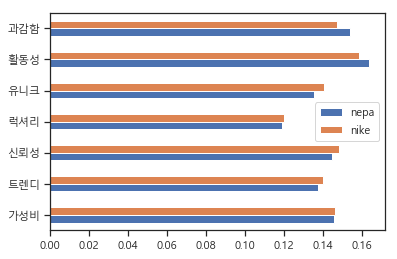

In [76]:
df = pd.read_pickle('id_dict.pkl')
df /= df.sum()
df[['nepa','nike']].plot.barh()#xlim=(0.05,0.2))

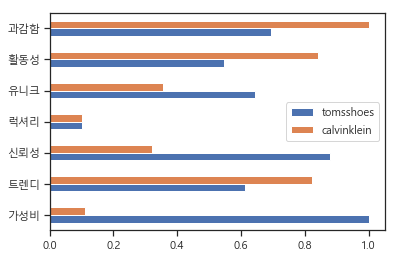

In [235]:
df = pd.read_pickle('id_dict.pkl')
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1))
X_train_minmax = min_max_scaler.fit_transform(df)
df2 = df.copy()
df2[:] = X_train_minmax
df2[['tomsshoes', 'calvinklein']].plot.barh()

In [99]:
df2.T

,가성비,트렌디,신뢰성,럭셔리,유니크,활동성,과감함
032c,0.168580,0.672264,0.100000,0.480496,0.742232,0.608089,1.000000
1017alyx9sm,0.100000,0.832815,0.431374,0.198050,0.854428,0.628230,1.000000
8seconds,0.269826,0.719249,0.495287,0.100000,0.579789,0.471486,1.000000
99percentis,0.100000,0.637772,0.638521,0.376230,1.000000,0.752606,0.749003
a.p.c,0.100000,1.000000,0.818241,0.123340,0.513708,0.113041,0.301206
aape,0.100000,0.441167,0.633920,0.459888,0.765124,1.000000,0.885823
abecrombiefitch,0.922305,0.100000,0.759782,0.339914,0.371949,0.245519,1.000000
acnestudios,0.100000,0.918412,0.500838,0.545509,0.775408,0.615348,1.000000
acoldwall,0.725525,0.476435,0.560664,0.100000,0.693372,0.635692,1.000000
acronym,0.884874,0.428708,0.878407,0.100000,0.843218,1.000000,0.877615


In [204]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(df2.T)
# cluster = KMeans(n_clusters=10, random_state=0).fit(X_reduced)
# cluster = DBSCAN().fit(X_reduced)
cluster = AffinityPropagation().fit(X_reduced)
clustered = pd.Series(cluster.labels_, index=df2.columns); clustered

032c                    14
1017alyx9sm             23
8seconds                24
99percentis             17
a.p.c                    0
aape                    17
abecrombiefitch         10
acnestudios             14
acoldwall                8
acronym                 20
adererror                0
adidas                  18
adidasoriginal           9
aecawhite               12
aimeleondore             0
aldo                     9
alexandermcqueen        15
alexanderwang           22
allsaints               22
alphaindustry           18
ambush                  17
ami                     16
amiri                   13
antisocialsocialclub    25
arcteryx                 6
asics                    6
awakeny                  5
balensiaga              11
bally                    1
balmain                 15
                        ..
tomsshoes                4
topshop                 23
topten                  18
toryburch               15
tumi                     1
ugg                      4
u

In [233]:
clustered.index[clustered==25]

Index(['antisocialsocialclub', 'discovery', 'mindbridge', 'palace',
       'placesplusfaces', 'reigningchamp', 'richardson',
       'rockymountainfeatherbed', 'soup', 'woolrich'],
      dtype='object')

25

In [7]:
def preproc(text, remove_url=True, remove_mention=True, remove_hashtag=False):
    LINEBREAK = r'\n' # str.replace에서는 r'\n'으로 검색이 안된다
    RT = ' rt '
    EMOJI = r'[\U00010000-\U0010ffff]'
    DOTS = '…'
    LONG_BLANK = r'[ ]+'
    
    # \u3131-\u3163\uac00-\ud7a3 는 한글을 의미함
    # URL = r'(?P<url>(https?://)?(www[.])?[^ \u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b([^ \u3131-\u3163\uac00-\ud7a3]*))'
    URL1 = r'(?:https?:\/\/)?(?:www[.])?[^ :\u3131-\u3163\uac00-\ud7a3]+[.][a-z]{2,6}\b(?:[^ \u3131-\u3163\uac00-\ud7a3]*)'
    URL2 = r'pic.twitter.com/[a-zA-Z0-9_]+'
    URL = '|'.join((URL1, URL2))
    
    HASHTAG = r'#(?P<inner_hashtag>[^ #@]+)'
    MENTION = r'@(?P<inner_mention>[^ #@]+)' 
    
    #PTNS = '|'.join((LINEBREAK, RT, URL, HASHTAG, MENTION, EMOJI))
    
    #out = {}
    text = re.sub('|'.join((LINEBREAK, RT, EMOJI, DOTS)), '', text.lower())
    
    if remove_url:
        text = re.sub(URL, '', text)

    if remove_mention:
        text = re.sub(MENTION, '', text)        
    else:
        text = re.sub(MENTION, ' \g<inner_mention>', text)
        
    if remove_hashtag:
        text = re.sub(HASHTAG, '', text)        
    else:
        text = re.sub(HASHTAG, ' \g<inner_hashtag>', text)
        
    return re.sub(LONG_BLANK, ' ', text).strip()


def tokenize(fname, textcol):
    df = pd.read_pickle(fname)
    item = df.columns.levels[0][0]
    tokenized = []
    
    for doc in df.droplevel(0, axis=1)[textcol]:
        text = preproc(doc)
        _tokenized = [t[0] for t in twitter.pos(text, norm=True, stem=True) if t[1] not in ['Punctuation', 'Josa']]
        tokenized.append(_tokenized)
    
    return item, tokenized

In [10]:
preproc(pd.read_pickle('twitter_data/allsaints (2010.01.01-2019.02.07).pkl').droplevel(0,axis=1).text.iloc[210], remove=True)

{'urls': ['http://www.fashionn.com/board/read_new.php?table=1006&number=21030&sns_number=989523…',
  'pic.twitter.com/2rys36ronu'],
 'hashtags': ['올세인츠', '올세인츠비치컬렉션pic.twitter.com/2rys36ronu'],
 'mention': [],
 'text': "올세인츠,  여름 한정판 '헌팅턴 비치 컬렉션' 출시"}

In [146]:
preproc(pd.read_pickle('twitter_data/allsaints (2010.01.01-2019.02.07).pkl').droplevel(0,axis=1).text.iloc[42])

'수퍼스타 커플신발 신세계백화점강남점 시댁선물사러나왔다가 allsaints 거울이좋네 ㅋㅋㅋ 얼마만에 같이나온건지~ 데이트하는기분'

In [145]:
pd.read_pickle('twitter_data/allsaints (2010.01.01-2019.02.07).pkl').droplevel(0,axis=1).text[42]

'#수퍼스타#커플신발#신세계백화점강남점 #시댁선물사러나왔다가 #ALLSAINTS #거울이좋네 ㅋㅋㅋ#얼마만에 같이나온건지~#데이트하는기분 https://www.instagram.com/p/-8DHERpvz-/\xa0'